# Predicting Toronto Ferry Activity

## Install libraries

In [ ]:
# Data handling and analysis
!pip install pandas numpy

# Plotting
!pip install matplotlib seaborn

# Time series decomposition and stats
!pip install statsmodels

# scikit-learn
!pip install scikit-learn

# Holiday calendars
!pip install holidays

# YAML configuration parsing
!pip install pyyaml

# LightGBM
!pip install lightgbm

# SHAP values for model explainability
!pip install shap


## Import packages

In [14]:
# Standard library imports
from datetime import date, timedelta
import yaml

# Numerical and data analysis libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

# Machine learning libraries
import lightgbm as lgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as MAE

# Model explainability
import shap

# Holiday calendars
import holidays



## Custom classes and functions

In [15]:
class DataLoader:
    """
    A class to load and preprocess time-series data from a CSV file.

    Attributes:
        file_path (str): Path to the CSV file.
        id_col (str): Name of the column containing unique identifiers.
        timestamp_col (str): Name of the column containing timestamp values.
        redemption_col (str): Name of the column containing redemption counts.
        sales_col (str): Name of the column containing sales counts.
        df (pd.DataFrame or None): Loaded and preprocessed DataFrame.
    """

    def __init__(self, file_path, id_col, timestamp_col, redemption_col, sales_col):
        """
        Initializes the DataLoader with file path and relevant column names.

        Args:
            file_path (str): Path to the CSV file.
            id_col (str): Column name for IDs.
            timestamp_col (str): Column name for timestamps.
            redemption_col (str): Column name for redemption data.
            sales_col (str): Column name for sales data.
        """
        self.file_path = file_path
        self.id_col = id_col
        self.timestamp_col = timestamp_col
        self.redemption_col = redemption_col
        self.sales_col = sales_col
        self.df = None

    def load_data(self):
        """
        Loads the CSV data, parses dates, sorts by timestamp, 
        and sets the timestamp column as the index.

        Returns:
            pd.DataFrame: Preprocessed DataFrame with timestamp index.
        """
        self.df = pd.read_csv(
            self.file_path,
            dtype={self.id_col: int, self.redemption_col: int, self.sales_col: int},
            parse_dates=[self.timestamp_col]
        )
        self.df.sort_values(self.timestamp_col, inplace=True)
        self.df.set_index(self.timestamp_col, inplace=True)
        return self.df

class BasicDataAnalyzer:
    """
    A class for performing basic exploratory data analysis (EDA) on time-series data.

    Attributes:
        df (pd.DataFrame): The input DataFrame containing time-series data.
        redemption_col (str): Column name for redemption data.
        sales_col (str): Column name for sales data.
        id_col (str, optional): Column name for unique identifiers, if any.
    """

    def __init__(self, df, redemption_col, sales_col, id_col=None):
        """
        Initializes the BasicDataAnalyzer with the dataset and relevant column names.

        Args:
            df (pd.DataFrame): Input DataFrame.
            redemption_col (str): Column name for redemption data.
            sales_col (str): Column name for sales data.
            id_col (str, optional): Column name for ID data. Defaults to None.
        """
        self.df = df
        self.redemption_col = redemption_col
        self.sales_col = sales_col
        self.id_col = id_col

    def perform_basic_eda(self):
        """
        Performs basic exploratory data analysis:
            - Displays summary statistics
            - Displays missing value counts
            - Plots time series for redemption and sales
            - Displays and plots correlation matrix
        """
        print("Summary Statistics (excluding ID column):")
        cols_to_describe = [self.redemption_col, self.sales_col]
        print(self.df[cols_to_describe].describe())

        print("\nMissing Values:")
        print(self.df.isnull().sum())

        # Plot Redemption Count time series
        plt.figure(figsize=(14, 5))
        plt.plot(self.df.index, self.df[self.redemption_col], color='blue', label=self.redemption_col)
        plt.title(f'{self.redemption_col} Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot Sales Count time series
        plt.figure(figsize=(14, 5))
        plt.plot(self.df.index, self.df[self.sales_col], color='orange', label=self.sales_col)
        plt.title(f'{self.sales_col} Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Correlation heatmap
        corr = self.df[[self.redemption_col, self.sales_col]].corr()
        print("\nCorrelation Matrix:")
        print(corr)

        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation between Redemption and Sales')
        plt.show()

class MissingValueHandler:
    """
    A class to handle missing dates in time-series data, resample to daily frequency,
    and impute missing values using historical averages.

    Attributes:
        df (pd.DataFrame): The input time-indexed DataFrame.
    """

    def __init__(self, df):
        """
        Initializes the MissingValueHandler with a DataFrame.

        Args:
            df (pd.DataFrame): Input DataFrame with a datetime index.
        """
        self.df = df.copy()
        self.df.index = pd.to_datetime(self.df.index)
        self.df.sort_index(inplace=True)

    def count_missing_days(self):
        """
        Identifies and counts missing calendar days in the time series.

        Returns:
            list: A list of missing dates (as datetime.date objects).
        """
        full_range = pd.date_range(
            start=self.df.index.min().normalize(),
            end=self.df.index.max().normalize(),
            freq='D'
        )
        actual_dates = self.df.index.normalize().unique()
        missing_dates = full_range.difference(actual_dates)

        print(f"Total missing days: {len(missing_dates)}")
        if len(missing_dates) > 0:
            print("Sample missing dates:", missing_dates[:10])

        return list(missing_dates.date)

    def resample_daily_sum(self):
        """
        Resamples the data to daily frequency by summing values.
        Fills missing days with zeros implicitly during resampling.

        Returns:
            pd.DataFrame: DataFrame resampled to daily frequency.
        """
        df_daily = self.df.resample('D').sum()
        return df_daily

    def impute_with_historical_avg(self, df_daily, missing_dates):
        """
        Imputes missing daily values using the historical average for the same calendar day
        (month and day) across different years.

        Args:
            df_daily (pd.DataFrame): Daily-resampled DataFrame.
            missing_dates (list): List of missing dates to impute (datetime.date objects).

        Returns:
            pd.DataFrame: DataFrame with imputed values for the missing days.
        """
        df_imputed = df_daily.copy()
        numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns

        for missing_day in missing_dates:
            month_day = (missing_day.month, missing_day.day)

            same_day_other_years = df_imputed[
                (df_imputed.index.month == month_day[0]) &
                (df_imputed.index.day == month_day[1]) &
                (df_imputed.index.date != missing_day)
            ]

            if not same_day_other_years.empty:
                # Compute mean, round, and cast to int
                imputed_values = same_day_other_years[numeric_cols].mean().round().astype(int)
                df_imputed.loc[pd.to_datetime(missing_day), numeric_cols] = imputed_values

                print(f"Imputed values for missing date {missing_day}:")
                print(imputed_values)
                print("-" * 40)

        return df_imputed

class OutlierDetection:
    """
    A class for detecting outliers in time-series data using STL decomposition
    and Isolation Forest on the residual component.

    Attributes:
        df (pd.DataFrame): The input DataFrame.
        config (dict, optional): Optional configuration dictionary.
    """

    def __init__(self, df, config=None):
        """
        Initializes the OutlierDetection class.

        Args:
            df (pd.DataFrame): Input DataFrame containing time-series data.
            config (dict, optional): Optional configuration dictionary for outlier detection.
        """
        self.df = df.copy()
        self.config = config or {}

    def detect_outliers_stl_isolation(self, numeric_col, period, contamination=None, random_state=42, plot=True):
        """
        Detects outliers in a numeric time-series column using STL decomposition and
        Isolation Forest on the residuals.

        Args:
            numeric_col (str): Name of the numeric column to analyze.
            period (int): Seasonal period for STL decomposition.
            contamination (float, optional): Proportion of outliers in the data.
                If None, will try to read from config; if still None, defaults to 1/N.
            random_state (int): Random seed for Isolation Forest.
            plot (bool): Whether to plot the decomposition and detected outliers.

        Returns:
            pd.DataFrame: DataFrame with added columns:
                - 'trend': STL trend component
                - 'seasonal': STL seasonal component
                - 'resid': STL residual component
                - 'outlier': Isolation Forest outlier labels (-1 for outlier)
                - 'outlier_mask': Binary mask for outliers (1 = outlier, 0 = inlier)

        Raises:
            ValueError: If the specified column does not exist in the DataFrame.
        """
        if numeric_col not in self.df.columns:
            raise ValueError(f"Column '{numeric_col}' not found in DataFrame.")

        # Override contamination with config value if present
        if contamination is None:
            contamination = self.config.get('outlier_detection', {}).get('contamination')

        # Fallback default if nothing provided
        if contamination is None:
            contamination = 1 / len(self.df)

        # STL decomposition
        stl = STL(self.df[numeric_col], period=period, robust=True)
        res = stl.fit()
        self.df['trend'] = res.trend
        self.df['seasonal'] = res.seasonal
        self.df['resid'] = res.resid

        # Isolation Forest on residuals
        iso = IsolationForest(contamination=contamination, random_state=random_state)
        self.df['outlier'] = iso.fit_predict(self.df[['resid']])
        self.df['outlier_mask'] = (self.df['outlier'] == -1).astype(int)

        # Optional plotting
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

            axs[0].plot(self.df.index, self.df[numeric_col], label='Original', color='blue')
            axs[1].plot(self.df.index, self.df['trend'], label='Trend', color='orange')
            axs[2].plot(self.df.index, self.df['seasonal'], label='Seasonal', color='green')
            axs[3].plot(self.df.index, self.df['resid'], label='Residual', color='red')

            axs[3].scatter(
                self.df.index[self.df['outlier_mask'] == 1],
                self.df['resid'][self.df['outlier_mask'] == 1],
                color='black', label='Outliers', marker='x'
            )

            for ax in axs:
                ax.legend(loc='upper right')
                ax.grid(True)
                ylabel = ax.get_legend_handles_labels()[1][0] if ax.get_legend_handles_labels()[1] else ''
                ax.set_ylabel(ylabel)

            axs[-1].set_xlabel("Date")
            plt.tight_layout()
            plt.show()

        return self.df

class FeatureEngineer:
    """
    Engineer time-based and contextual features from a time-indexed DataFrame,
    including time components, holidays, seasonal categories, lagged features,
    rolling averages, and categorical encodings.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with a datetime index.
    config : dict, optional
        Configuration dictionary (default is None) with keys:
        - 'country' (str): Country code for holidays, default 'Canada'.
        - 'prov' (str): Province code for holidays, default 'ON'.
        - 'lag_days' (list of int): Lag days for lag features, default [1, 3].
        - 'rolling_windows' (list of int): Rolling window sizes, default [3, 7, 14].
    """

    def __init__(self, df: pd.DataFrame, config: dict = None):
        self.df = df.copy()
        self.config = config or {}

        self.country = self.config.get('country', 'Canada')
        if not isinstance(self.country, str):
            raise ValueError(f"Expected 'country' to be a string, got {type(self.country)}")

        self.prov = self.config.get('prov', 'ON')
        if not isinstance(self.prov, str):
            raise ValueError(f"Expected 'prov' to be a string, got {type(self.prov)}")

        self.lag_days = self.config.get('lag_days', [1, 3])
        if not isinstance(self.lag_days, list):
            raise ValueError(f"Expected 'lag_days' to be a list, got {type(self.lag_days)}")

        self.rolling_windows = self.config.get('rolling_windows', [3, 7, 14])
        if not isinstance(self.rolling_windows, list):
            raise ValueError(f"Expected 'rolling_windows' to be a list, got {type(self.rolling_windows)}")

    def _add_time_features(self):
        self.df['day_of_week'] = self.df.index.dayofweek
        self.df['day_name'] = self.df.index.day_name()
        self.df['month'] = self.df.index.month
        self.df['day_of_month'] = self.df.index.day
        self.df['week_of_year'] = self.df.index.isocalendar().week
        self.df['quarter'] = self.df.index.quarter
        self.df['is_weekend'] = self.df['day_of_week'].isin([5, 6]).astype(int)

        def week_of_month(dt):
            first_day = dt.replace(day=1)
            dom = dt.day
            adjusted_dom = dom + first_day.weekday()
            return int(np.ceil(adjusted_dom / 7.0))

        self.df['week_of_month'] = self.df.index.to_series().apply(week_of_month)

    def _add_holiday_features(self):
        years = self.df.index.year.unique()
        on_holidays = holidays.CountryHoliday(self.country, prov=self.prov)

        def add_toronto_specific_holidays(years_):
            civic_holidays = {}
            for year in years_:
                aug1 = date(year, 8, 1)
                first_monday = aug1 + timedelta(days=(7 - aug1.weekday()) % 7)
                civic_holidays[first_monday] = "Civic Holiday (Toronto)"
            return civic_holidays

        toronto_holidays = on_holidays.copy()
        toronto_holidays.update(add_toronto_specific_holidays(years))
        self.df['is_holiday'] = self.df.index.isin(toronto_holidays).astype(int)

    def _add_season_and_lags(self):
        def season(month):
            if month in [12, 1, 2]:
                return 'winter'
            elif month in [3, 4, 5]:
                return 'spring'
            elif month in [6, 7, 8]:
                return 'summer'
            else:
                return 'fall'

        self.df['season'] = self.df['month'].apply(season)

        for lag in self.lag_days:
            self.df[f'sales_lag_{lag}d'] = self.df['Sales Count'].shift(lag)
            self.df[f'redemption_lag_{lag}d'] = self.df['Redemption Count'].shift(lag)

    def _add_weekend_season_interaction(self):
        self.df['weekend_flag'] = self.df['is_weekend'].apply(lambda x: 'weekend' if x == 1 else 'weekday')
        self.df['weekend_season'] = self.df['weekend_flag'] + '_' + self.df['season']
        interaction_dummies = pd.get_dummies(self.df['weekend_season'], prefix='weekend_season')
        self.df = pd.concat([self.df, interaction_dummies], axis=1)
        self.df.drop(['weekend_flag', 'weekend_season'], axis=1, inplace=True)

    def _add_rolling_features(self):
        for window in self.rolling_windows:
            self.df[f'sales_roll_mean_{window}d'] = self.df['Sales Count'].rolling(window).mean()
            self.df[f'redemption_roll_mean_{window}d'] = self.df['Redemption Count'].rolling(window).mean()

    def _encode_time_categoricals(self):
        self.df = pd.get_dummies(
            self.df,
            columns=[
                'day_name',
                'day_of_week',
                'day_of_month',
                'season',
                'month',
                'quarter',
                'week_of_month'
            ],
            drop_first=False,
            prefix_sep='='
        )
        bool_cols = self.df.select_dtypes(include=['bool']).columns
        self.df[bool_cols] = self.df[bool_cols].astype(int)

    def transform(self) -> pd.DataFrame:
        """Run all feature engineering steps and return the transformed DataFrame."""
        self._add_time_features()
        self._add_holiday_features()
        self._add_season_and_lags()
        self._add_weekend_season_interaction()
        self._add_rolling_features()
        self._encode_time_categoricals()
        self.df.dropna(inplace=True)
        return self.df

    def plot_feature_distributions(self, columns=None, max_features=5):
        """
        Plot distributions of numeric features using histograms with KDE.

        Parameters
        ----------
        columns : list of str, optional
            List of columns to plot. If None, selects up to max_features numeric columns.
        max_features : int, optional
            Maximum number of features to plot if columns is None (default is 5).
        """
        if columns is None:
            numeric_cols = self.df.select_dtypes(include=['number']).columns
            numeric_cols = [col for col in numeric_cols if '=' not in col]
            columns = numeric_cols[:max_features]
        else:
            valid_cols = []
            for col in columns:
                if col in self.df.columns and pd.api.types.is_numeric_dtype(self.df[col]) and '=' not in col:
                    valid_cols.append(col)
            columns = valid_cols

        for col in columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(self.df[col].dropna(), kde=True, bins=30, color='skyblue')
            plt.title(f'Distribution of numeric feature: {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()


class SalesModel:
    """
    A modeling class that performs time-series cross-validation using
    a LightGBM regression model to predict daily sales count.

    Args:
        X (pd.DataFrame): Feature DataFrame including the target column.
        target_col (str): Name of the target column to predict.
        lgb_params_dict (dict, optional): Dictionary of LightGBM parameters.
            If None, parameters are loaded from 'config.yaml' or defaults are used.
        verbose (bool, optional): Whether to print progress messages. Defaults to True.
        plot (bool, optional): Whether to plot predictions and MAE summaries. Defaults to True.
    """

    def __init__(self, X, target_col, lgb_params_dict=None, verbose=True, plot=True):
        """
        Initialize the SalesModel with features, target column, and parameters.

        Raises:
            FileNotFoundError: If 'config.yaml' is not found and no parameters provided.
            Exception: For any other errors during config file reading.
        """
        self.X = X
        self.target_col = target_col
        self.results = {}
        self.models = {}
        self.verbose = verbose
        self.plot = plot
        self.cat_cols = ['day_name', 'season', 'day_weekend_combo']
        self.lgb_train_mae = {}
        self.lgb_valid_mae = {}

        default_params = {
            'objective': 'regression',
            'metric': 'mae',
            'verbosity': -1,
            'seed': 42,
            'num_boost_round': 10000,
            'learning_rate': 0.001
        }

        if lgb_params_dict is None:
            try:
                config = self.load_yaml_config()
                self.lgb_params = {**default_params, **config.get("lgb_params", {})}
            except FileNotFoundError:
                print("config.yaml not found. Using default LightGBM parameters.")
                self.lgb_params = default_params
            except Exception as e:
                print(f"Error reading config.yaml: {e}")
                self.lgb_params = default_params
        else:
            self.lgb_params = {**default_params, **lgb_params_dict}

    def load_yaml_config(self):
        """
        Load LightGBM configuration from 'config.yaml'.

        Returns:
            dict: Parsed YAML configuration dictionary.
        """
        with open("config.yaml", "r") as file:
            return yaml.safe_load(file)

    def score(self, truth, preds):
        """
        Calculate Mean Absolute Error (MAE) between truth and predictions.

        Args:
            truth (array-like): True target values.
            preds (array-like): Predicted target values.

        Returns:
            float: MAE score.
        """
        return np.mean(np.abs(truth - preds))

    def run_models(self, n_splits=4, test_size=365):
        """
        Perform time-series cross-validation, train LightGBM models,
        and store MAE results and models.

        Args:
            n_splits (int, optional): Number of splits for TimeSeriesSplit. Defaults to 4.
            test_size (int, optional): Size of test set for each split. Defaults to 365.

        Prints:
            MAE for each split and summary of results if verbose is True.

        Plots:
            Predictions for each split if plot is True.
        """
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        cnt = 0
        for train_idx, test_idx in tscv.split(self.X):
            X_train = self.X.iloc[train_idx].copy()
            X_test = self.X.iloc[test_idx].copy()

            for col in self.cat_cols:
                if col in X_train.columns:
                    X_train[col] = X_train[col].astype('category').cat.codes
                    X_test[col] = X_test[col].astype('category').cat.codes

            features = X_train.columns.drop(self.target_col)
            lgb_preds, model, evals_result = self._lightgbm_model(X_train, X_test, features)
            lgb_preds = pd.Series(lgb_preds, index=X_test.index)
            self.models[cnt] = model

            self.results[cnt] = self.score(X_test[self.target_col], lgb_preds)

            self.lgb_train_mae[cnt] = evals_result['train']['l1']
            self.lgb_valid_mae[cnt] = evals_result['valid']['l1']

            if self.verbose:
                print(f"Split {cnt}: LightGBM MAE = {self.results[cnt]:.2f}")

            if self.plot:
                self.plot_predictions(self.X[self.target_col], lgb_preds, lgb_preds.index, 'LightGBM')

            cnt += 1

        if self.verbose:
            print("\nSummary of LightGBM MAE per split:")
            print(pd.DataFrame.from_dict(self.results, orient='index', columns=['MAE']).round(2))

    def _lightgbm_model(self, X_train, X_test, features):
        """
        Train a LightGBM model and predict on the test set.

        Args:
            X_train (pd.DataFrame): Training feature set.
            X_test (pd.DataFrame): Testing feature set.
            features (list): List of feature column names.

        Returns:
            tuple: (predictions array, trained LightGBM model, evaluation results dict)
        """
        dtrain = lgb.Dataset(X_train[features], label=X_train[self.target_col])
        dvalid = lgb.Dataset(X_test[features], label=X_test[self.target_col])

        evals_result = {}

        model = lgb.train(
            self.lgb_params,
            dtrain,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.record_evaluation(evals_result)
            ]
        )

        preds = model.predict(X_test[features])
        return preds, model, evals_result

    def plot_predictions(self, full_truth, preds, preds_index, label):
        """
        Plot the predicted vs true values.

        Args:
            full_truth (pd.Series): Full series of true target values.
            preds (array-like): Predicted target values.
            preds_index (pd.Index): Index for the predictions (dates).
            label (str): Label for the predictions plot.
        """
        if not self.plot:
            return
        if self.verbose:
            print(f"Plotting predictions for: {label}")

        plt.figure(figsize=(12, 6))
        plt.plot(full_truth, label='Truth', linewidth=2, color='grey')
        plt.plot(preds_index, preds, label=label)
        plt.legend(fontsize=12)
        plt.title("Predictions vs Truth", fontsize=16)
        plt.ylabel("Sales Count", fontsize=14)
        plt.xlabel("Year", fontsize=14)
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    def explain_with_shap(self, split_num=None, max_display=10):
        """
        Generate and display SHAP summary plot for model explainability.

        Args:
            split_num (int, optional): Split number whose model to explain.
                Defaults to the last trained model.
            max_display (int, optional): Maximum number of features to display.
                Defaults to 10.
        """
        if split_num is None:
            split_num = max(self.models.keys(), default=None)

        if split_num is None or split_num not in self.models:
            print(f"Model for split {split_num} not found.")
            return

        model = self.models[split_num]

        features = self.X.drop(columns=[self.target_col])
        for col in self.cat_cols:
            if col in features.columns:
                features[col] = features[col].astype('category').cat.codes

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(features)

        shap.summary_plot(shap_values, features, max_display=max_display)

    def plot_mae_summary(self):
        """
        Plot the training and validation MAE per iteration and a bar chart of
        LightGBM MAE per split.

        Requires `run_models()` to be run beforehand to generate MAE data.
        """
        if not self.lgb_train_mae or not self.lgb_valid_mae:
            print("No LightGBM MAE data available. Run `run_models()` first.")
            return

        plt.figure(figsize=(14, 6))
        for split_num in sorted(self.lgb_train_mae.keys()):
            plt.plot(self.lgb_train_mae[split_num], label=f"Train MAE Split {split_num}", linestyle='-')
            plt.plot(self.lgb_valid_mae[split_num], label=f"Valid MAE Split {split_num}", linestyle='--')
        plt.xlabel('Iteration', fontsize=16)
        plt.ylabel('MAE', fontsize=16)
        plt.title('LightGBM Training and Validation MAE per Iteration', fontsize=16)
        plt.legend(fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.grid(False)  # Remove grid
        plt.tight_layout()
        plt.show()

        df_mae = pd.DataFrame.from_dict(self.results, orient='index', columns=['LightGBM MAE'])
        df_mae.index = ['Split ' + str(i+1) for i in df_mae.index]
        df_mae.plot(kind='bar', figsize=(10, 6), legend=True)
        plt.title("LightGBM MAE per Split", fontsize=16)
        plt.ylabel("MAE", fontsize=14)
        plt.xlabel("Split", fontsize=14)
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()


## Execute code

Summary Statistics (excluding ID column):
       Redemption Count    Sales Count
count     246425.000000  246425.000000
mean          46.814467      47.575352
std          101.663040      97.542517
min            0.000000       0.000000
25%            3.000000       3.000000
50%           10.000000      12.000000
75%           38.000000      45.000000
max         7216.000000    7229.000000

Missing Values:
_id                 0
Redemption Count    0
Sales Count         0
dtype: int64


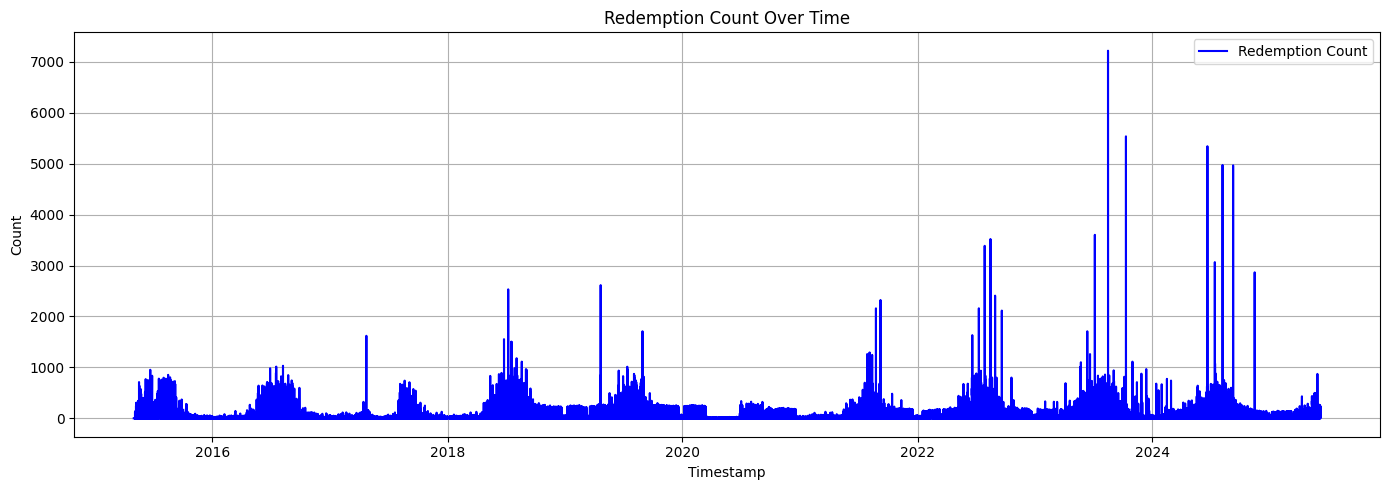

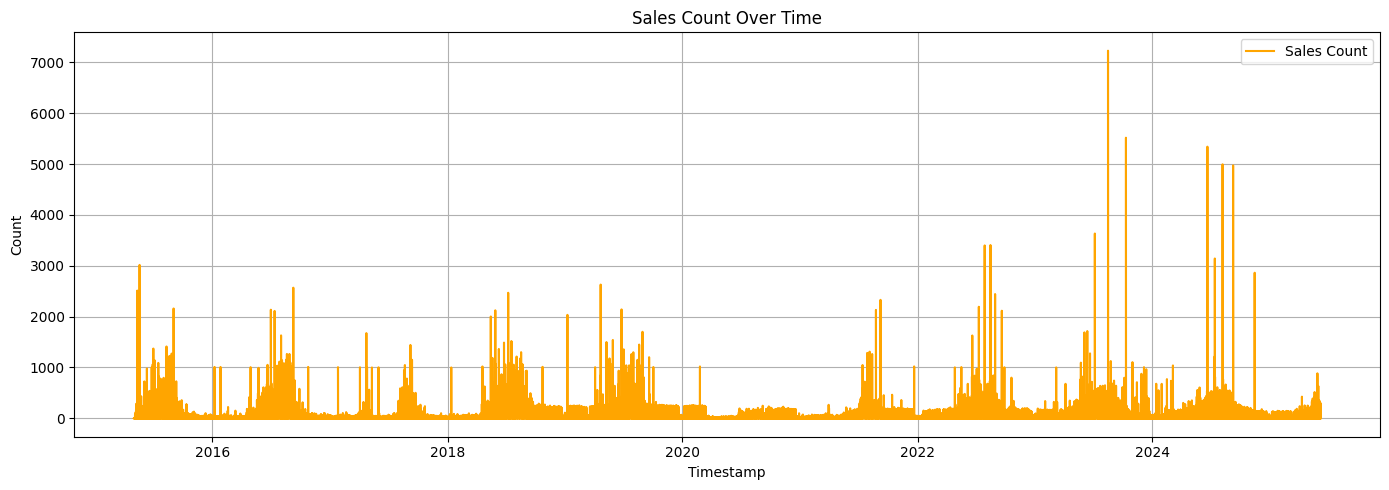


Correlation Matrix:
                  Redemption Count  Sales Count
Redemption Count          1.000000     0.912994
Sales Count               0.912994     1.000000


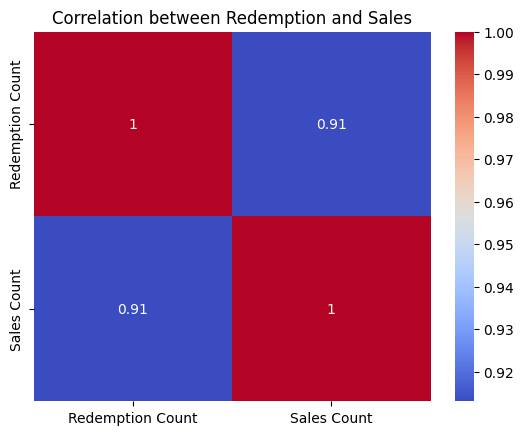

Total missing days: 6
Sample missing dates: DatetimeIndex(['2015-05-02', '2015-05-03', '2018-01-04', '2021-02-21',
               '2021-02-22', '2025-01-26'],
              dtype='datetime64[ns]', freq=None)
Imputed values for missing date 2015-05-02:
_id                 7359182
Redemption Count       1468
Sales Count            1520
dtype: int32
----------------------------------------
Imputed values for missing date 2015-05-03:
_id                 7426413
Redemption Count       1472
Sales Count            1422
dtype: int32
----------------------------------------
Imputed values for missing date 2018-01-04:
_id                 6559655
Redemption Count        526
Sales Count             483
dtype: int32
----------------------------------------
Imputed values for missing date 2021-02-21:
_id                 6964014
Redemption Count        715
Sales Count             569
dtype: int32
----------------------------------------
Imputed values for missing date 2021-02-22:
_id                 

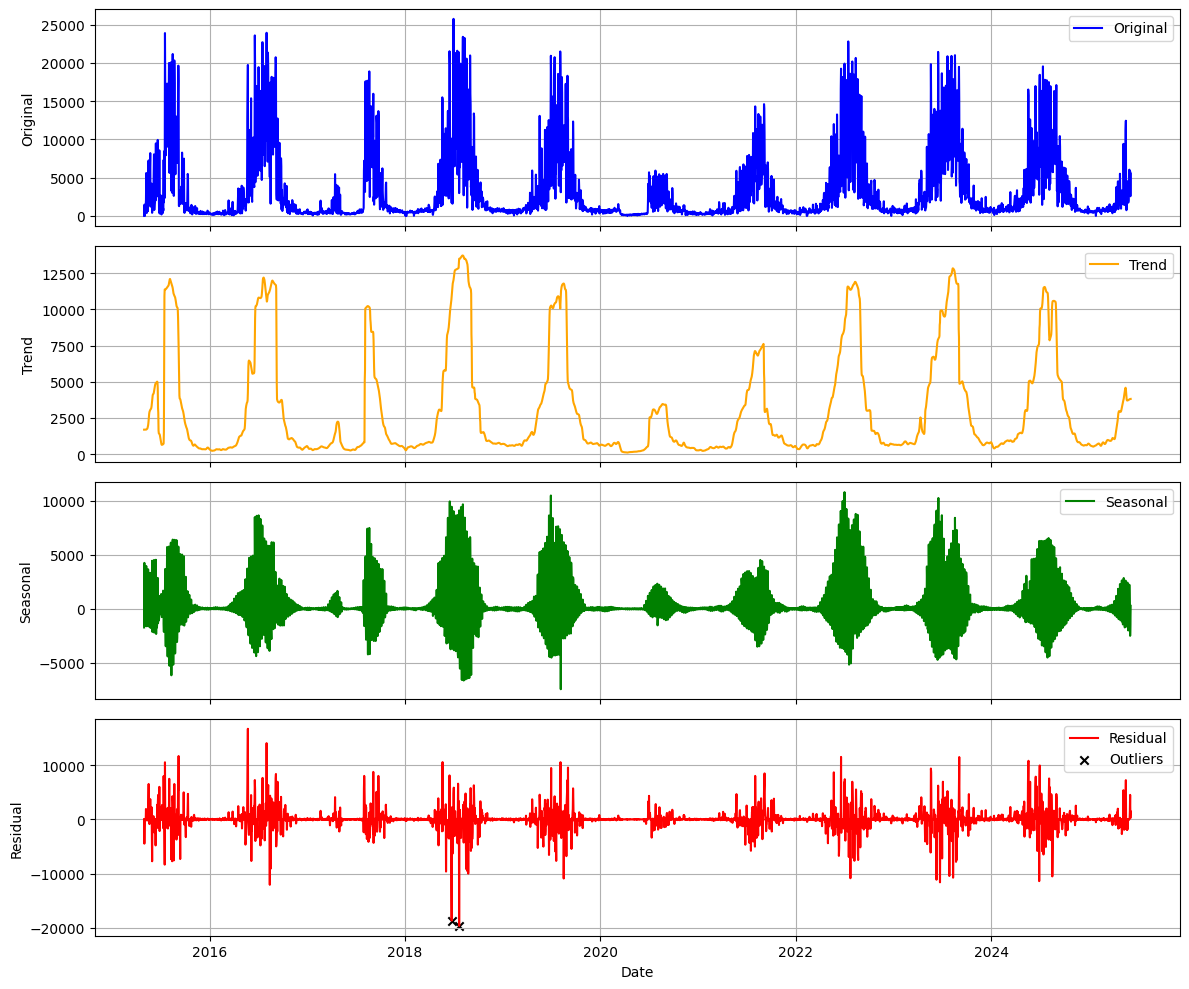

C:\Users\khiza\AppData\Local\Temp\ipykernel_14036\575123658.py:372: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  self.df['is_holiday'] = self.df.index.isin(toronto_holidays).astype(int)



Plotting feature distributions...


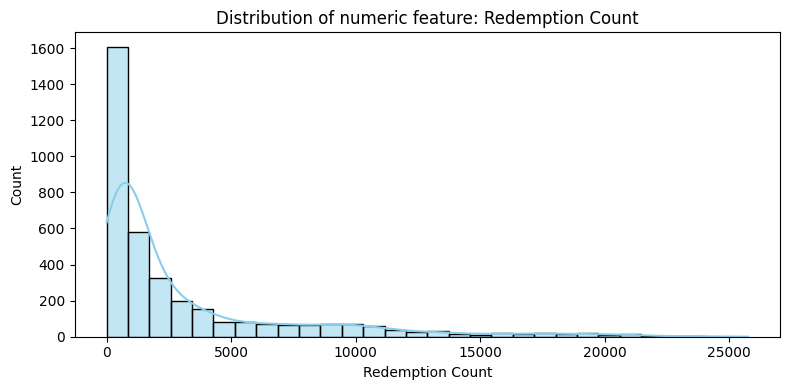

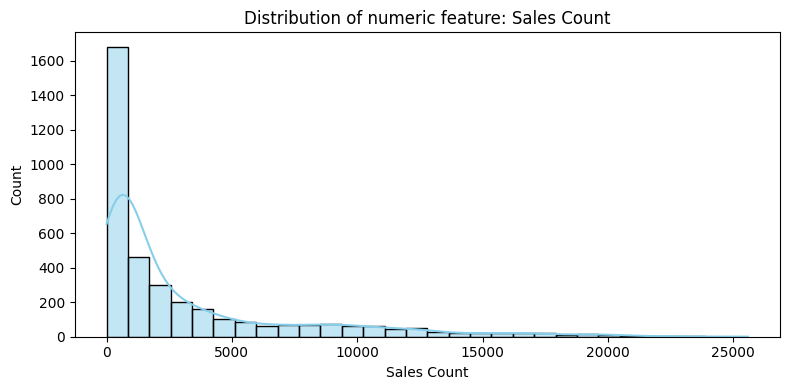

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	train's l1: 760.78	valid's l1: 735.217
Split 0: LightGBM MAE = 735.22
Plotting predictions for: LightGBM


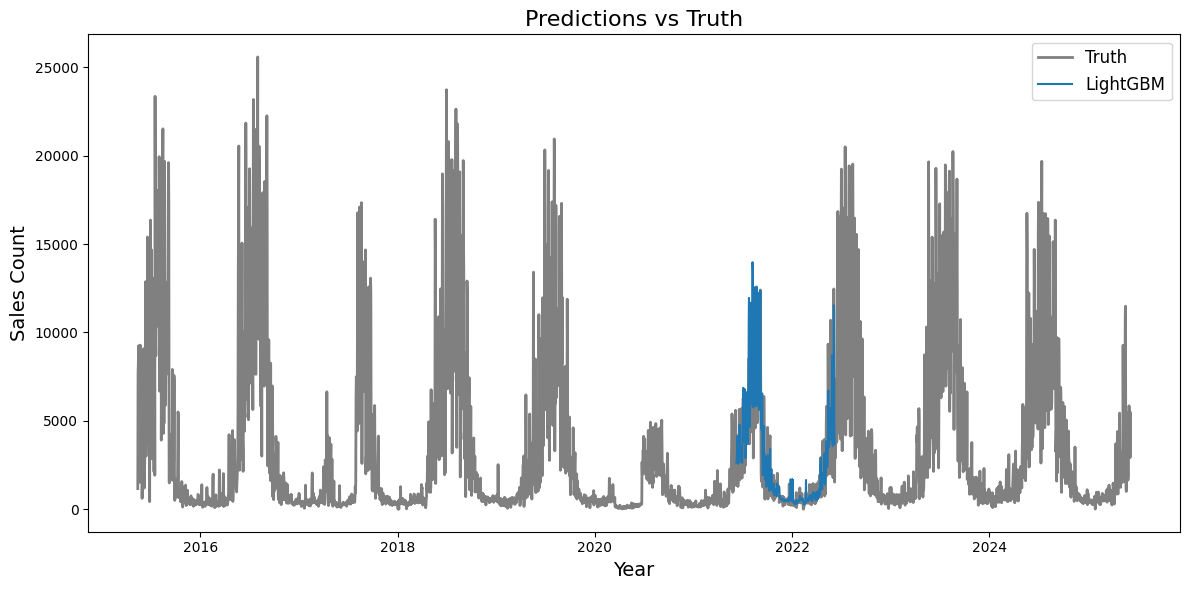

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	train's l1: 723.919	valid's l1: 981.169
Split 1: LightGBM MAE = 981.17
Plotting predictions for: LightGBM


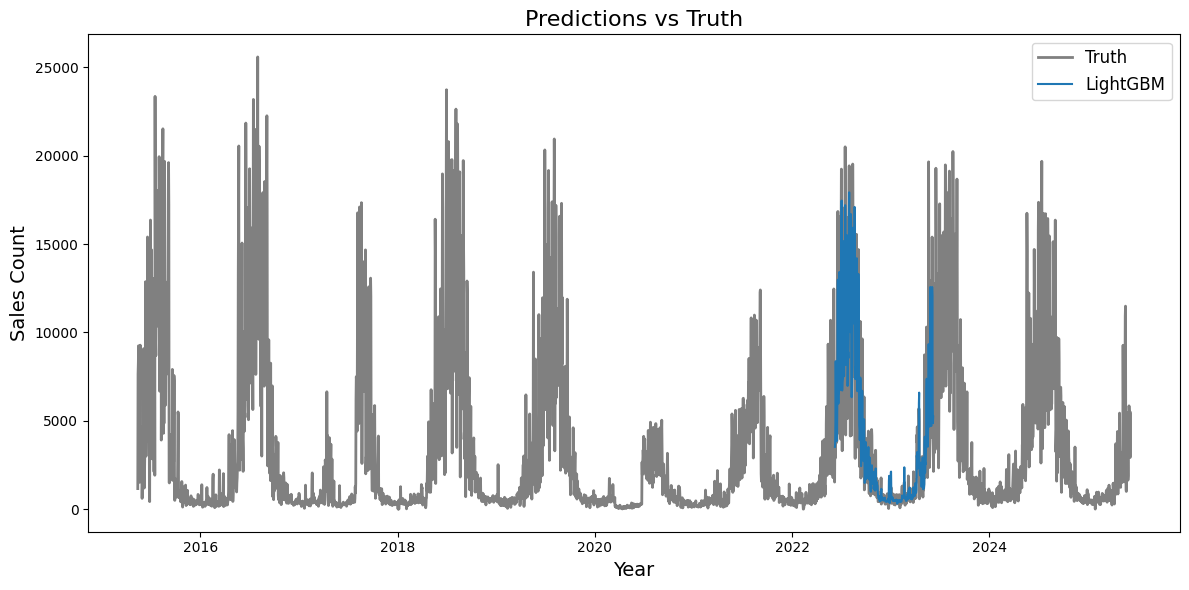

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	train's l1: 763.919	valid's l1: 992.033
Split 2: LightGBM MAE = 992.03
Plotting predictions for: LightGBM


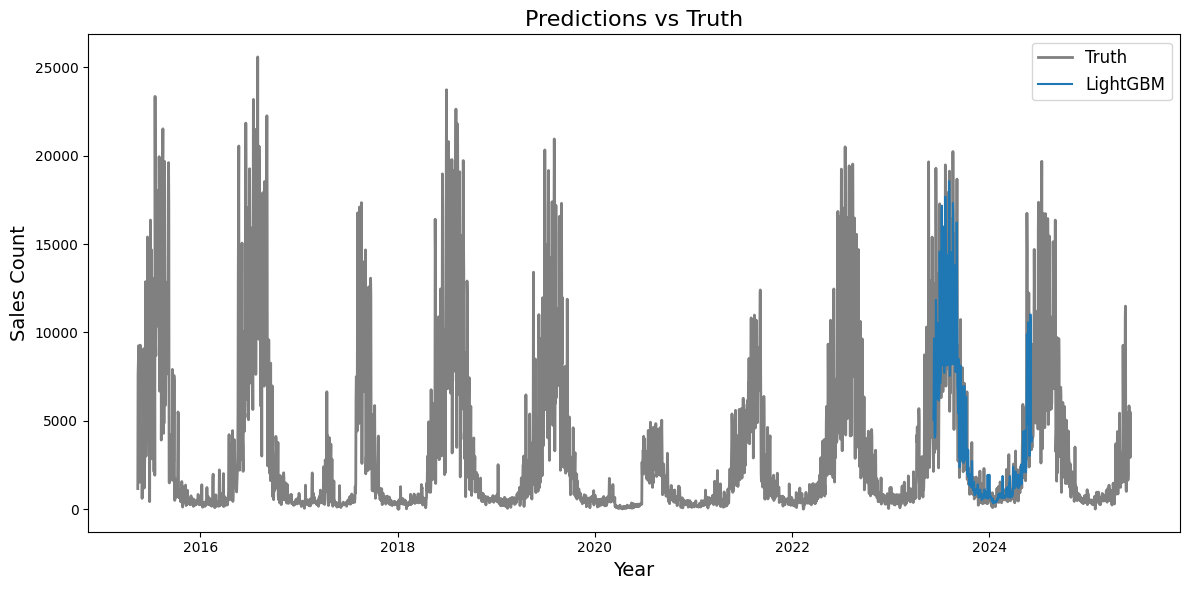

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[453]	train's l1: 715.787	valid's l1: 939.117
Split 3: LightGBM MAE = 939.12
Plotting predictions for: LightGBM


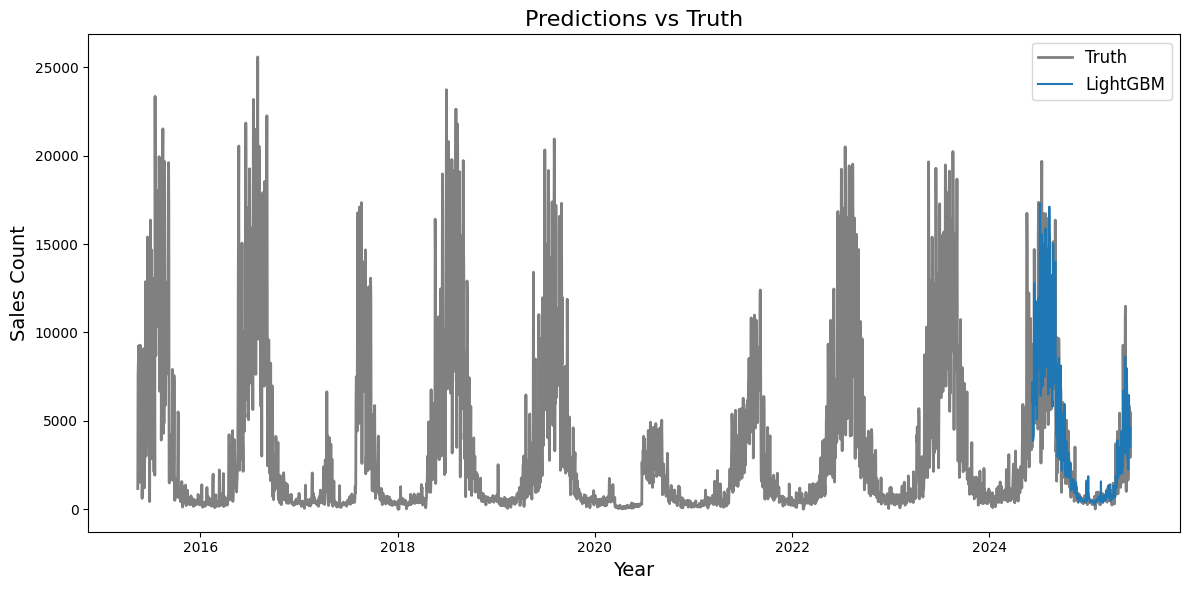


Summary of LightGBM MAE per split:
      MAE
0  735.22
1  981.17
2  992.03
3  939.12
MAE results per split:
   Split     MAE
0      0  735.22
1      1  981.17
2      2  992.03
3      3  939.12


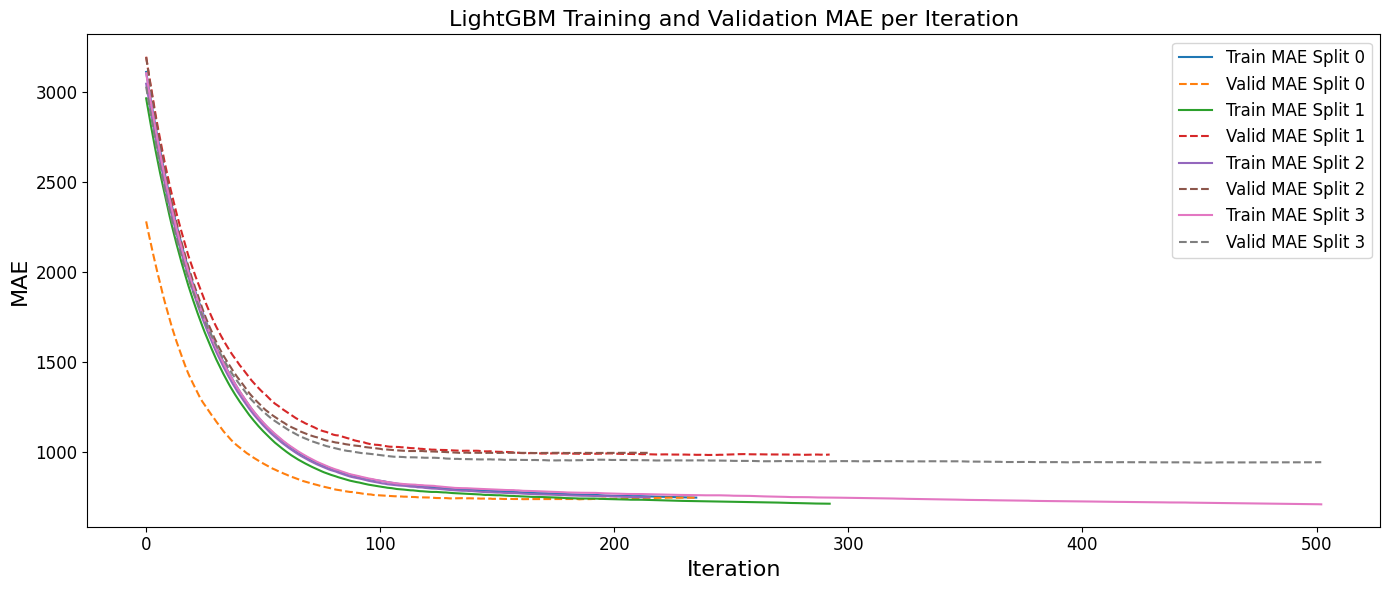

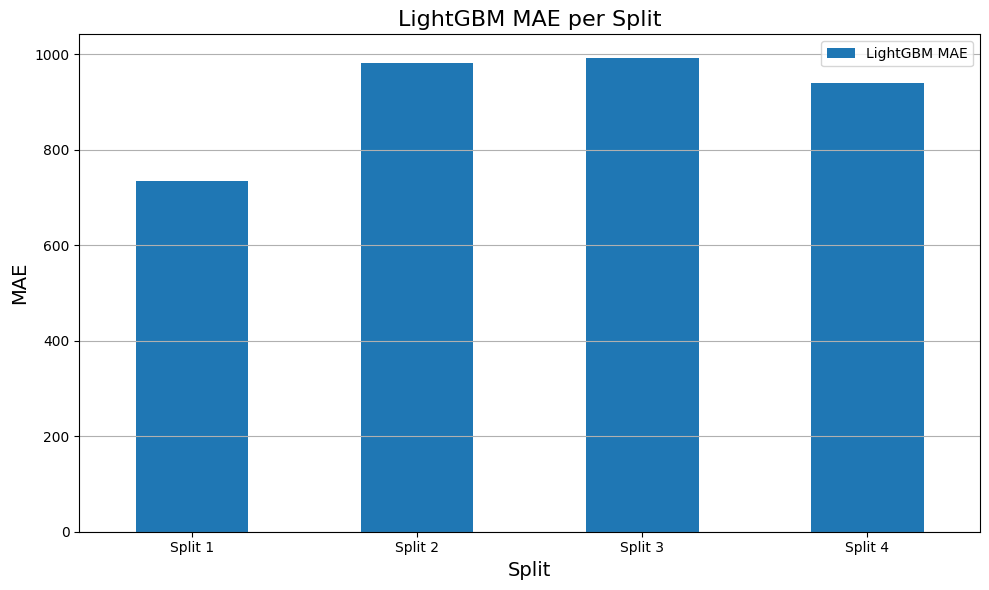

SHAP plot for feature importance


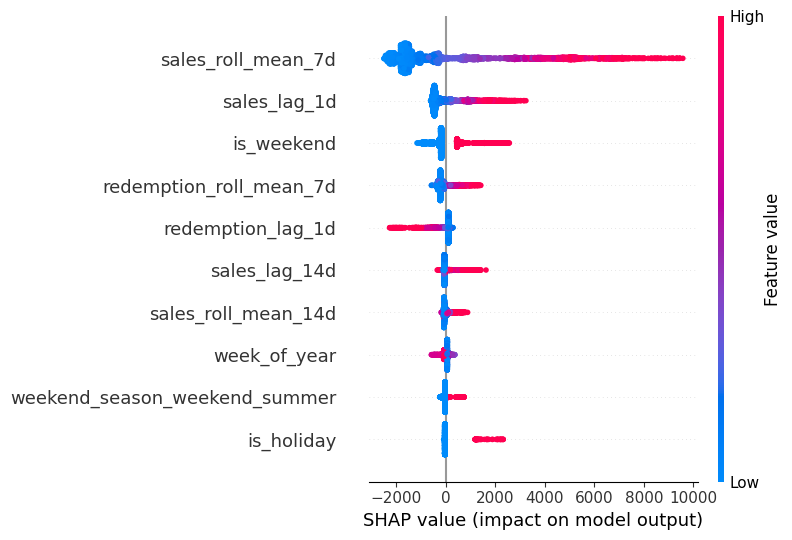

In [16]:
"""
Main script execution.

Loads configuration, reads data, performs EDA, handles missing values,
detects outliers, engineers features, trains and evaluates the
RedemptionModel using LightGBM, and produces SHAP explanations.
"""

# Load configuration from 'config.yaml'
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Extract data-related configuration values
data_path = config['data']['filepath']
timestamp_col = config['data']['timestamp_col']
id_col = config['data']['id_col']
redemption_col = config['data']['redemption_col']
sales_col = config['data']['sales_col']

# Initialize data loader and load the dataset
loader = DataLoader(data_path, id_col, timestamp_col, redemption_col, sales_col)
df = loader.load_data()

# Perform basic exploratory data analysis before missing value handling
analyzer = BasicDataAnalyzer(df, redemption_col, sales_col, id_col)
analyzer.perform_basic_eda()

# Initialize missing value handler and count missing days
mv_handler = MissingValueHandler(df)
missing_days = mv_handler.count_missing_days()

# Resample data to daily frequency summing up values
df = mv_handler.resample_daily_sum()

# Impute missing days with historical average if missing days exist
if missing_days:
    df = mv_handler.impute_with_historical_avg(df, missing_days)

# Detect outliers using STL decomposition and Isolation Forest method
outlier_detector = OutlierDetection(df, config=config)
outlier_df = outlier_detector.detect_outliers_stl_isolation(
    numeric_col=redemption_col,
    period=7,
    contamination=None,  # contamination level set internally from config
    plot=True
)

# Feature engineering: apply transformations based on features config
features_config = config.get('features', {})
fe = FeatureEngineer(df, config=features_config)
df = fe.transform()

print("\nPlotting feature distributions...")
# Plot distributions for key numeric features
fe.plot_feature_distributions(columns=[redemption_col, sales_col])

# Extract LightGBM parameters from config, use empty dict if not specified
lgb_params = config.get('lightgbm_params', {})

# Drop columns not needed for modeling
drop_cols = ['_id', redemption_col]
drop_cols = [col for col in drop_cols if col in df.columns]  # Ensure columns exist
df = df.drop(drop_cols, axis=1)

# Initialize and run the sales model with LightGBM parameters
rm = SalesModel(df, sales_col, lgb_params_dict=lgb_params)
rm.run_models()

# Print MAE results per split if available
if hasattr(rm, 'results'):
    print("MAE results per split:")
    df_results = pd.DataFrame(list(rm.results.items()), columns=['Split', 'MAE']).round(2)
    print(df_results)

# Plot MAE summary for all splits
rm.plot_mae_summary()

print("SHAP plot for feature importance")
# Generate SHAP explanation for the last split model
rm.explain_with_shap(split_num=3)  # Last split
